# **Entrega 3 - Lunar Lander con Q-Learning**

### **1. Bibliotecas**

In [2]:
import sys
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import pygame
from pygame.locals import *

### **2. Jugando a mano**

A continuación se puede jugar un episodio del lunar lander. Se controlan los motores con el teclado. Notar que solo se puede realizar una acción a la vez (que es parte del problema), y que en esta implementación, izq toma precedencia sobre derecha, que toma precedencia sobre el motor principal.

In [4]:
# Inicializar pygame (para el control con el teclado) y el ambiente
pygame.init()
env = gym.make('LunarLander-v2', render_mode='human')
env.reset()
pygame.display.set_caption('Lunar Lander')

clock = pygame.time.Clock()
done = False

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True
            break

    keys = pygame.key.get_pressed()

    # Map keys to actions
    if keys[K_LEFT]:
        action = 3  # Fire left orientation engine
    elif keys[K_RIGHT]:
        action = 1 # Fire right orientation engine
    elif keys[K_UP]:
        action = 2  # Fire main engine
    else:
        action = 0  # Do nothing

    estado, _, terminated, truncated, _ = env.step(action)
    env.render()
    clock.tick(10)

    if terminated or truncated:
        done = True

env.close()
pygame.quit()

## **3. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [5]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 16

#          Estado:
#          (x,            y,            x_vel,        y_vel,        theta,        theta_vel,    pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona de aterrizaje (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
# print ("Bins: ", bins)

env.close()

def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices, taking the closest bin."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            # Encuentra el índice del valor más cercano en los bins
            closest_index = np.argmin(np.abs(bins[i] - state[i]))
            state_disc.append(closest_index)
    return tuple(state_disc)

In [6]:
# Ejemplos
print(discretize_state([0.0, 0.0, 0, 0, 0, 0, 1, 1], bins)) # En la zona de aterrizaje y quieto
print(discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)) # Comenzando la partida, arriba y en el centro

(7, 0, 7, 7, 7, 7, 1, 1)
(7, 14, 7, 7, 7, 7, 0, 0)


## **4. Agentes y la interacción con el entorno**

Vamos a definir una interfaz para nuestro agente:

In [7]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado: el estado en el que se encuentra actualmente el agente
            - max_accion: el espacio de acciones posibles
            - explorar: si se debe elegir una acción de forma que explore el espacio de estados, o eligiendo la que mejor recompensa cree que devuelve
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado) -> None:
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self) -> None:
        """Actualizar estructuras al final de un episodio"""
        pass

Para un agente aleatorio, la implementación sería:

In [8]:
class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado) -> None:
        # No aprende
        pass

    def fin_episodio(self) -> None:
        # Nada que actualizar
        pass

Luego podemos definir una función para ejecutar un episodio con un agente dado:

In [9]:
def ejecutar_episodio(agente, aprender=True, render=None, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode=render).env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
        
    if (aprender):
        agente.fin_episodio()

    entorno.close()
    return recompensa_total

In [10]:
# Ejecutamos un episodio con el agente aleatorio y modo render 'human', para poder verlo
ejecutar_episodio(AgenteAleatorio(), render = 'human')

-416.2429461738583

Podemos ejecutar este ambiente muchas veces y tomar métricas al respecto

In [15]:
AgenteAleatorio = AgenteAleatorio()
recompensa_episodios = []

exitos = 0
num_episodios = 100
for i in range(num_episodios):
    recompensa = ejecutar_episodio(AgenteAleatorio, render='human')
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]

print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")

TypeError: 'AgenteAleatorio' object is not callable

### **5. Programando un agente que aprende**

La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:

In [16]:
'''
Hiperparametros
  Politica de exploracion (random, epsilon-greedy)
  epsilon
  Politica de aprendizaje (Aprender en el momento / Aprender al final)
  Cantidad de bins = 16
'''

class AgenteRL(Agente):

    def __init__(self, epsilon=0.1, politica_exploracion='epsilon-greedy', aprender_inmediatamente=True) -> None:
        '''
        Parametros
        ----------
        epsilon: Usado si politica_exploracion=epsilon-greedy / Probabilidad de exploracion en cada paso
        politica_exploracion: Funcion que determinará la accion a tomar en caso de encontrarse explorando. ( random, epsilon-greedy)
        aprender_inmediatamente: Si el agente debe aprender en el momento o al final del episodio haciendo un reccorido "hacia atras"

        Utiliza una función de aprendizaje Q-Learning no-determinista, mediante la formula:
        Q(s, a) = (1 - alfa) * Q(s, a) + alfa * (recompensa + max(Q(s', a')))
        donde alfa=1/cantidad_visitas(s, a)
        '''
        super().__init__()
        self.Q = {}
        self.cantidad_visitas = {}
        
        self.epsilon = epsilon
        self.politica_exploracion = politica_exploracion
        self.aprender_inmediatamente = aprender_inmediatamente

        # En caso de que aprenda al finalizar el episodio, se guardan las acciones tomadas
        self.acciones_tomadas = []

    def elegir_accion(self, estado, max_accion, explorar=True) -> int:
        estado = discretize_state(estado, bins)
        self.max_accion = max_accion

        # La tabla Q y cantidad_visitas se genera a medida que se visitan estados
        if estado not in self.Q:
            self.Q[estado] = {i: 0 for i in range(max_accion)}
            for accion in range(max_accion):
                self.cantidad_visitas[(estado, accion)] = 0     

        if explorar: # Explorar

            match self.politica_exploracion:
                case 'random':
                    return random.randrange(max_accion)
            
                case 'epsilon-greedy':
                    if random.random() < self.epsilon:
                        return random.randrange(max_accion)
                    else:
                        return max(self.Q[estado], key=self.Q[estado].get)

        else: # Explotacion
            return max(self.Q[estado], key=self.Q[estado].get)

    def aprender(self, estado_anterior, estado_actual, accion, recompensa, terminado) -> None:
        estado_anterior = discretize_state(estado_anterior, bins)
        estado_actual   = discretize_state(estado_actual, bins)
        
        # La tabla Q y cantidad_visitas se genera a medida que se visitan estados
        for estado in [estado_anterior, estado_actual]:
            if estado not in self.Q:
                self.Q[estado] = {i: 0 for i in range(self.max_accion)}
                for a in range(4):
                    self.cantidad_visitas[(estado, a)] = 0
            
        self.cantidad_visitas[(estado_anterior, accion)] += 1 

        if (self.aprender_inmediatamente):
            alfa = 1 / self.cantidad_visitas[(estado_anterior, accion)]
            self.Q[estado_anterior][accion] = (1 - alfa) * self.Q[estado_anterior][accion] + alfa * (recompensa + max(self.Q[estado_actual].values()))
        else:
            self.acciones_tomadas.append((estado_anterior, estado_actual, accion, recompensa))     


    def fin_episodio(self) -> None:
        '''
        En caso de que el agente aprenda al final del episodio, se recorre hacia atras las acciones tomadas durante
        el episodio y se actualizan los valores de Q
        En caso contrario, no se hace nada
        '''
        if (not self.aprender_inmediatamente):
            for i in range(len(self.acciones_tomadas)-1, -1, -1):
                estado_anterior, estado_actual, accion, recompensa = self.acciones_tomadas[i]
                alfa = 1 / self.cantidad_visitas[(estado_anterior, accion)]
                self.Q[estado_anterior][accion] = (1 - alfa) * self.Q[estado_anterior][accion] + alfa * (recompensa + max(self.Q[estado_actual].values()))

            self.acciones_tomadas = []

Y ejecutar con el muchos episodios:

In [17]:
agente = AgenteRL()
exitos = 0
recompensa_episodios = []
num_episodios = 100
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")

Tasa de éxito: 0.0. Se obtuvo -144.36276908473633 de recompensa, en promedio


Analizar los resultados de la ejecución anterior, incluyendo:
Agus
 * Un análisis de algunos 'cortes' de la matriz Q y la política (p.e. qué hace la nave cuando está cayendo rápidamente hacia abajo, sin rotación) 

 Yo
 * Un análisis de la evolución de la recompensa promedio
 * Continuar con explicacion de parametros

 Juako
 * Un análisis de los casos de éxito 
 * Un análisis de los casos en el que el agente falla

### **6. Parametros utilizados**

### Agente implementado

El agente implementado cuenta con varios hiperparametros a configurar, estos son:

- Politica de exploración: Esta puede ser random, es decir, siempre elige una acción aleatoria cuando aprende, o epsilon-greedy, en la cual se utiliza otro valor (epsilon).
- Epsilon: Probabilidad de tomar una acción aleatoria en cada paso, al contrario de tomar la mejor elección conocida. Utilizado unicamente cuando la política de exploración es epsilon-greedy.
- Cuando actualizar Q: También se puede variar el momento en el cual el agente "aprende". Se puede configurar para que el agente aprenda al tomar cada acción, o que guarde por separado todas las acciones tomadas durante un episodio, y al finalizarlo, actualizar la tabla Q yendo "hacia atras" en todas las acciones tomadas.
- Cantidad de bins: El espacio de estados en el que se encuentra la nave (posicion x, posicion y, velocidad x, velocidad y, angulo de rotación, velocidad de rotación) puede también variarse.

Durante las siguientes partes, se discutirán las elecciones de cada valor en particular.

Por otro lado, al aplicar una discretización del espacio de estados, las recompensas devueltas dada una tupla (estado, acción) es no determinista. Es por esto que se utiliza el parámetro alfa (learning rate), el cual se calcula en cada paso como 1 / cantidad_visitas(s,a).

Por último, el espacio de estados puede alcanzar valores en el orden de los millones, por lo que, para evitar el uso excesivo de memoria, la tabla Q y el mapa cantidad_visitas son generados a medida que se recorren los estados.


### Política de exploración

A continuación, se prueba el uso de las dos politicas de exploración implementadas

- Random
- Epsilon-greedy, con valores de epsilon 0.1, 0.3, 0.5, 0.7 y 0.9.

Para esto, se genera un agente para cada configuración y se lo entrena durante 20000 episodios. Luego, se compararán los resultados obtenidos con cada uno al utilizar unicamente explotación.

In [13]:
num_episodios = 20000

# Prueba con random
agente_random = AgenteRL(politica_exploracion='random')
for i in range(1, num_episodios):
    _ = ejecutar_episodio(agente_random, aprender=True)

print("Finalizado entrenamiento con random")

# Prueba epsilon-greedy
agentes_epsilon = []  # Array para almacenar los agentes epsilon
for epsilon in [0.1, 0.3, 0.5, 0.7, 0.9]:
    agente_epsilon = AgenteRL(politica_exploracion='epsilon-greedy', epsilon=epsilon)
    for i in range(1, num_episodios):
        _ = ejecutar_episodio(agente_epsilon, aprender=True)

    agentes_epsilon.append(agente_epsilon) 

    print(f'Finalizado entrenamiento con epsilon={epsilon}')

Finalizado entrenamiento con random
Finalizado entrenamiento con epsilon=0.1
Finalizado entrenamiento con epsilon=0.3
Finalizado entrenamiento con epsilon=0.5
Finalizado entrenamiento con epsilon=0.7
Finalizado entrenamiento con epsilon=0.9


A continuación, se ejecutan durante 1000 episodios cada agente con explotación, y se compara el porcentaje de exitos (episodios en los cuales se consiguen más de 200 puntos) y el promedio obtenido durante todos los episodios.

In [17]:
promedios = [] 
exitos = []

recompensa_episodios = []
cant_exitos = 0
for i in range(1000):
    recompensa = ejecutar_episodio(agente_random, aprender=False)
    if (recompensa >= 200):
        cant_exitos += 1
    recompensa_episodios += [recompensa]
promedios.append(np.mean(recompensa_episodios))
exitos.append(cant_exitos/1000)

for agente in agentes_epsilon:
    recompensa_episodios = []
    cant_exitos = 0
    for i in range(1000):
        recompensa = ejecutar_episodio(agente, aprender=False)
        if (recompensa >= 200):
            cant_exitos += 1
        recompensa_episodios += [recompensa]
    promedios.append(np.mean(recompensa_episodios))
    exitos.append(cant_exitos/1000)

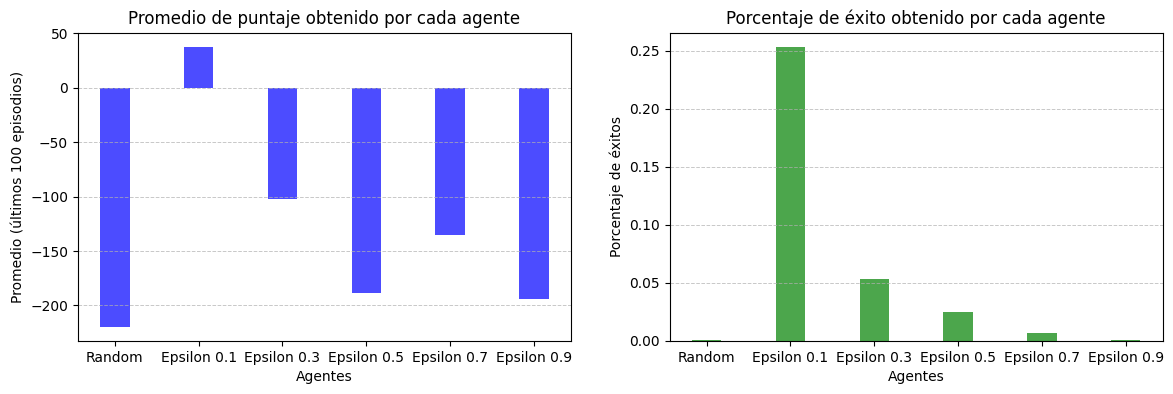

In [27]:
agentes = ['Random', 'Epsilon 0.1', 'Epsilon 0.3', 'Epsilon 0.5', 'Epsilon 0.7', 'Epsilon 0.9']
bar_width = 0.35
indices = np.arange(len(agentes))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Gráfica del promedio
axes[0].bar(indices, promedios, bar_width, color='b', alpha=0.7)
axes[0].set_xlabel('Agentes')
axes[0].set_ylabel('Promedio (últimos 100 episodios)')
axes[0].set_title('Promedio de puntaje obtenido por cada agente')
axes[0].set_xticks(indices)
axes[0].set_xticklabels(agentes)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Gráfica de éxitos
axes[1].bar(indices, exitos, bar_width, color='g', alpha=0.7)
axes[1].set_xlabel('Agentes')
axes[1].set_ylabel('Porcentaje de éxitos')
axes[1].set_title('Porcentaje de éxito obtenido por cada agente')
axes[1].set_xticks(indices)
axes[1].set_xticklabels(agentes)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.show()



Se observa como el agente que utiliza la política de exploración epsilon-greedy con epsilon=0.1 obtiene los mejores resultados, con un promedio de aproximadamente 30 puntos, y un porcentaje de exito de aproximadamente 25%.
Por lo tanto, en las siguientes secciones, haremos uso de agentes que utilicen la politica de exploración epsilon-greedy con epsilon=0.1.

### Aprender inmediatamente vs al final

Utilizando los valores de la política de exploración ópima hallada en la parte anterior, se compararán las evoluciones de los promedios de las recompensas al hacer que el agente aprenda al tomar cada acción, o guardando todas las acciones tomadas y sus recompensas, y haciendo una ejecución "hacia atras", para acelerar el tiempo de entrenaimento.
El promedio se calculará sobre los puntajes obtenidos durante los últimos 100 episodios, de forma que se pueda observar claramente su evolución, y los puntajes obtendios cuando el agente aun no tenía ningún entrenamiento no afecten los cálculos al medir los resultados del agente luego de cierto número de episodios.

In [ ]:
num_episodios = 40000

agente_epsilon_inmediato = AgenteRL(politica_exploracion='epsilon-greedy', epsilon=0.1, aprender_inmediatamente=True)
recompensa_parcial = []
promedios_recompensas_inmediato = []
for i in range(1, num_episodios):
    recompensa = ejecutar_episodio(agente_epsilon_inmediato, aprender=True, max_iteraciones=500)
    recompensa_parcial.append(recompensa)

agente_epsilon_final = AgenteRL(politica_exploracion='epsilon-greedy', epsilon=0.1, aprender_inmediatamente=False)
recompensa_parcial = []
promedios_recompensas_final = []
for i in range(1, num_episodios):
    recompensa = ejecutar_episodio(agente_epsilon_final, aprender=True, max_iteraciones=500)
    recompensa_parcial.append(recompensa)


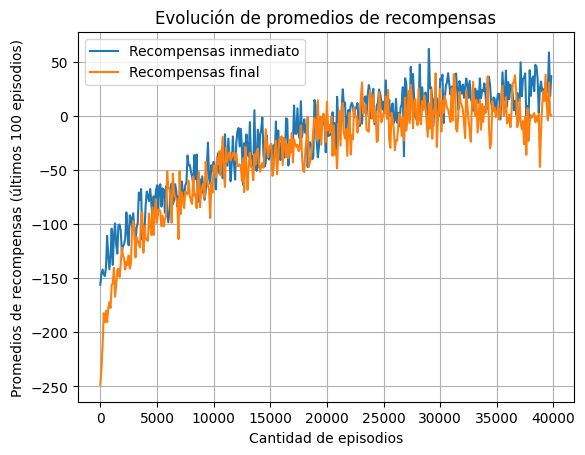

In [12]:
x_values = [i * 100 for i in range(len(promedios_recompensas_inmediato))]

y_values_inmediato = promedios_recompensas_inmediato
y_values_final = promedios_recompensas_final

plt.plot(x_values, y_values_inmediato, label='Recompensas inmediato')
plt.plot(x_values, y_values_final, label='Recompensas final')
plt.title('Evolución de promedios de recompensas')
plt.xlabel('Cantidad de episodios')
plt.ylabel('Promedios de recompensas (últimos 100 episodios)')
plt.legend()
plt.grid()
plt.show()

Al comparar ambas metodologías, se observa como el aprender de forma inmediata da resultados ligeramente superiores a su contraparte. Aun así ambas formas poseen algunas similitudes:
- Crecen de igual manera.
- Ambas alcanzan promedios de puntajes positivos.
- Parecen comenzar a converger luego de alcanzar un promedio de 0 puntos.

En las siguientes secciones, se utilizará entonces un agente que actualice su tabla Q inmediatamente luego de tomar una acción.

### Número de bins

El número de bins empleado hasta ahora fue den n=16, obtenido mediante prueba y error, probando diferentes configuraciones.
Este número parece funcionar por dos razones:
- Un número más bajo provocaría que se pierda información detallada como por ejemplo sobre la posición o la velocidad actual, puesto que se esta pasando de un espacio continuo a uno discreto. 
- Tomando en cuenta que el orden del espacio de estados se encuentra en los millones, por ejemplo, para n=20 el número de estados posibles es 20^6 * 4 = 256.000.000, por lo que aumentos pequeños en el número de bins provocan una ampliación muy grande en el número de estados, por lo que el tiempo de entrenamiento necesario para que nuestro agente pueda aprender de forma correcta aumenta de forma exponencial.

En resumen, n=16 es un equilibrio entre la información perdida de cada estado por la discretización, y el tiempo de entrenamiento necesario de nuestro agente.

# **Otras secciones que les pinte agregar**

In [19]:
agente_optimo = AgenteRL(politica_exploracion='epsilon-greedy', epsilon=0.1, aprender_inmediatamente=True)

num_episodios = 1_000_000
for i in range(1, num_episodios):
    _ = ejecutar_episodio(agente_optimo, aprender=True)
    if (i%1000==0):
        print(i)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [76]:
cayendo = []

for estado in list(agente_optimo.Q):
    if estado[3] < 7 and (estado[4] == 7 or estado[4] == 6) and (estado[5] == 7 or estado[5] == 6):
        cayendo.append(estado)


estado_acciones = []
for estado in cayendo:
    acciones = list(agente_optimo.Q[estado].values())

    estado_acciones.append((estado, np.argmax(acciones)))


cant = [0, 0, 0, 0]

for ea in estado_acciones:
    cant[ea[1]] += 1

print(cant)

[2442, 1455, 2124, 1787]


In [79]:
cayendo = []

for estado in list(agente_optimo.Q):
    if estado[4] < 5:
        cayendo.append(estado)


estado_acciones = []
for estado in cayendo:
    acciones = list(agente_optimo.Q[estado].values())

    estado_acciones.append((estado, np.argmax(acciones)))


cant = [0, 0, 0, 0]

for ea in estado_acciones:
    cant[ea[1]] += 1

print(cant)

[1384, 1155, 443, 414]


In [20]:
num_exitos = 0
puntajes=[]

for i in range(1000):
    recompensa = ejecutar_episodio(agente_optimo, aprender=False, render=None)
    puntajes.append(recompensa)
    if recompensa>=200:
        num_exitos += 1
        print(f"Episodio {i}")
        print(f"Puntaje {recompensa}")
        print("")

print(f"Porcentaje de exitos: {num_exitos/1000}")
print(f"Promedio de recompensas: {np.mean(puntajes)}")


Episodio 1
Puntaje 266.5397459624863

Episodio 8
Puntaje 231.83698910565516

Episodio 9
Puntaje 274.39784807036887

Episodio 14
Puntaje 267.4460748991961

Episodio 16
Puntaje 250.62904109848517

Episodio 26
Puntaje 266.3962475496943

Episodio 27
Puntaje 206.79803479842042

Episodio 28
Puntaje 271.96465316163363

Episodio 29
Puntaje 242.05962605213813

Episodio 30
Puntaje 259.1251049866139

Episodio 34
Puntaje 221.4851807264218

Episodio 36
Puntaje 213.36664055501288

Episodio 39
Puntaje 268.8682632215157

Episodio 41
Puntaje 256.1055554964678

Episodio 44
Puntaje 249.16647741251452

Episodio 49
Puntaje 267.0221860174513

Episodio 52
Puntaje 234.10529798010955

Episodio 54
Puntaje 261.3579068874969

Episodio 55
Puntaje 201.16019220438193

Episodio 56
Puntaje 225.76565929642018

Episodio 59
Puntaje 251.04201819259504

Episodio 61
Puntaje 239.79183334971287

Episodio 70
Puntaje 255.5019565285053

Episodio 71
Puntaje 234.02848301967236

Episodio 72
Puntaje 270.30994390027934

Episodio 73
P

### **7. Casos de éxito y fracaso**

### **8.Limitantes y posibles mejoras**

- Dado que se trabaja en un espacio continuo, la necesidad de discretizar para que el entrenamiento sea viable limita la cantidad de información con la que nuestro agente trabaja. Esta es una limitante inherente al propio problema a resolver, por lo que no existe una manera clara de resolverlo.

- Nuestro agente no es capaz de utilizar la información del suelo para elegir mejores acciones, y no tenemos forma de saber como esto afecta en la etapa de aprendizaje. Esto podría mejorarse codificando la información de como esta construido el suelo en cada episodio, y utilizando esta información como parte del espacio de estados.

- Por último, el limitante más claro es el tiempo dedicado al entrenamiento y el poder de cómputo disponible para el equipo. Puesto que a mayor capacidad de procesamiento, se podrían utilizar un valor más alto en el número de bins utilizado, aumentando la información con la que trabaja el agente. 

